In [1]:
import numpy as np
from sklearn.calibration import calibration_curve
import os
import matplotlib.pyplot as plt

In [2]:
def reliability_terciles(tercile, region, model, season, path_in):
    '''
    Computes the reliability statistics for tercile-based probabilistic forecasts.

    Parameters:
        tercile (int): The tercile category (1, 2, or 3).
        region (str): The region identifier ('r1', 'r2', 'r3').
        model (str): The forecast model ('cfsv2' or 'seas5').
        season (str): The season identifier. Must be either 'djf' or 'jja' (uppercase).
        path_in (str): The path to the directory containing the input data files.

    Returns:
        binned_probability_observed (numpy.array): Observed relative frequencies per probability bin.
        binned_probability_forecasted_corrected (numpy.array): Corrected forecast probabilities per bin.
        binned_relative_frequency (numpy.array): Relative frequencies for sharpness diagrams.
    '''
    file_name_in = os.path.join(path_in, f'terciles_prob_and_reference_{season.lower()}_{region}.npz')
    data_in = np.load(file_name_in)
    
    prob = data_in[model.lower()]
    cat_obs = data_in['merra2']
    prob = prob.reshape((3,prob.shape[1]*prob.shape[2]))
    cat_obs = cat_obs.reshape((cat_obs.shape[0]*cat_obs.shape[1]))
    
    forecast_probability = prob[tercile - 1,:]
    
    dichotomous_observed = np.zeros(cat_obs.size)
    dichotomous_observed[cat_obs==tercile] = 1
    
    # Define Thresholds
    bin_edges = [0.0,0.25, 0.5,0.75,1]
    bin_indices = np.digitize(prob[tercile - 1,:], bin_edges, right=True)
    
    bined_frecuency = np.histogram(bin_indices, 
                                   bins=np.arange(1, len(bin_edges)+1))[0]
    
    
    # Calculate predicted probability and reference frequency for each bin
    n_bins = 4
    prob_true, prob_pred = calibration_curve(dichotomous_observed, 
                                             forecast_probability, 
                                             n_bins=n_bins, strategy='uniform')
    
    bined_probability_forecasted = prob_pred
    bined_probability_observed = prob_true
    
    # Correct the controids of bined_probability_forecasted
    threshold_inf = np.arange(0,1,0.25)
    threshold_sup = np.arange(0.25,1.25,0.25)
    prob_corrected = np.arange(0.25/2,1, 0.25)
    
    idx_common = []
    for ii in range(bined_probability_forecasted.size):
        idx_i = bined_probability_forecasted[ii] > threshold_inf
        idx_ii = bined_probability_forecasted[ii] <= threshold_sup
        idx_common.append(np.where(idx_i & idx_ii)[0])
    
    bined_probability_forecasted_corrected = prob_corrected[idx_common]
    
    # Calculate relative frequencies to be used in sharpness diagrams
    n_tot = cat_obs.shape[-1]
    bined_relative_frecuency = bined_frecuency/n_tot
    
    return(bined_probability_observed, bined_probability_forecasted_corrected, bined_relative_frecuency)

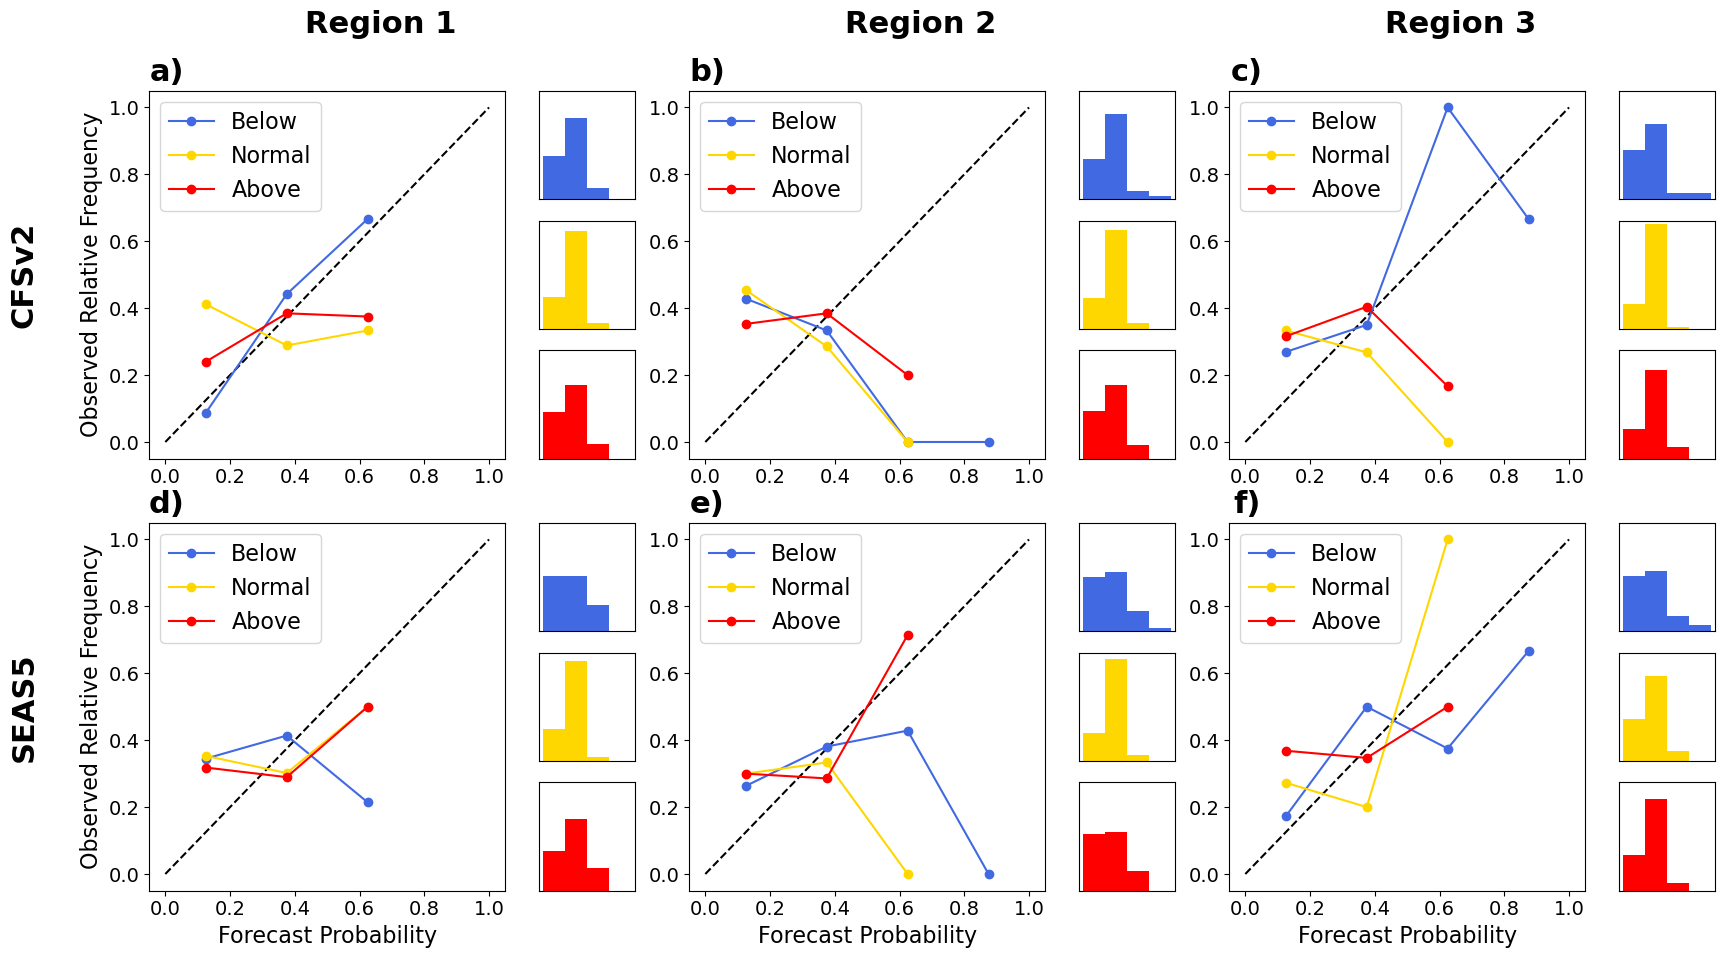

In [3]:
def plot_reliability_diagrams_terciles(path_in, season, save_image = False, path_out = '', file_name_out=''):
    '''
    Plots reliability diagrams for tercile-based probabilistic forecasts in three regions with height density of wind farms

    Parameters:
        path_in (str): Path to input data.
        season (str): Season for which the reliability diagrams are generated. Must be either 'DJF' or 'JJA'.
        save_image (bool, optional): If True, saves the figure. Default is False.
        path_out (str, optional): Path to save the figure if save_image is True.
        file_name_out (str, optional): Name of the output file. Defaults to 'reliability_diagram_tercile_<season>.jpeg'.
    '''
    season = season.upper()
    models = ['CFSv2', 'SEAS5']
    regions = ['r1', 'r2', 'r3']
    labels = [['a)', 'b)', 'c)'], ['d)', 'e)', 'f)']]
    bin_edges = [0.0, 0.25, 0.5, 0.75, 1]
    
    fig = plt.figure(figsize=(18, 8))
    model_positions = {'CFSv2': (1, 0.54), 'SEAS5': (0.46, 0.0)}
    region_positions = {'r1': (0.03, 0.30), 'r2': (0.33, 0.60), 'r3': (0.63, 0.90)}
    
    for i, model in enumerate(models):
        top, bottom = model_positions[model]
        
        for j, region in enumerate(regions):
            left, right = region_positions[region]
            
            gs = fig.add_gridspec(nrows=3, ncols=4, left=left, right=right, wspace=0.35, hspace=0.2, top=top, bottom=bottom)
            
            prob_obs, prob_forecast, freq_bins = zip(*[reliability_terciles(k, region, model.lower(), season.lower(), path_in) for k in range(1, 4)])
            
            # Reliability Diagram
            ax1 = fig.add_subplot(gs[:, :3])
            ax1.plot([0, 1], [0, 1], linestyle='--', color='black')
            ax1.plot(prob_forecast[0], prob_obs[0], marker='o', linestyle='-', color='royalblue', label='Below')
            ax1.plot(prob_forecast[1], prob_obs[1], marker='o', linestyle='-', color='gold', label='Normal')
            ax1.plot(prob_forecast[2], prob_obs[2], marker='o', linestyle='-', color='red', label='Above')
            
            if model == 'SEAS5':
                ax1.set_xlabel('Forecast Probability', fontsize=16)
            if region == 'r1':
                ax1.set_ylabel('Observed Relative Frequency', fontsize=16)
                ax1.text(-0.35, 0.5, model, ha='center', va='center', fontweight='bold', fontsize=22, rotation='vertical', transform=ax1.transAxes)
            
            ax1.annotate(labels[i][j], xy=(0.05, 1.05), xycoords='axes fraction', fontsize=22, fontweight='bold', ha='center', va='center')
            ax1.tick_params(axis='both', labelsize=14)
            ax1.legend(fontsize=16)
            
            # Frequency Histograms / Sharpness Diagrams
            for k in range(3):
                ax = fig.add_subplot(gs[k, -1])
                ax.bar(np.arange(1, len(bin_edges)), freq_bins[k], width=1, color=['royalblue', 'gold', 'red'][k])
                ax.set_ylim(0, 0.8)
                ax.set_xticks([])
                ax.set_yticks([])
            
            if model == 'CFSv2':
                ax1.text(0.65, 1.18, f'Region {j+1}', ha='center', va='center', fontweight='bold', fontsize=22, transform=ax1.transAxes)

    if save_image:
        if not bool(file_name_out):
            file_name_out = f'reliability_diagram_tercile_{season}.jpeg'
        if not bool(path_out):
            path_out = path_in
        plt.savefig(os.path.join(path_out, file_name_out), dpi=700, bbox_inches='tight')
    
    plt.show()


path_in = '../../../outputs/probabilistic_forecasts/'
season = 'DJF'
plot_reliability_diagrams_terciles(path_in, season)
